### Classifications can be used to categorize text into different groups.

![image](./images/1.png)

### Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

![image](./images/2.png)

### Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

# sample
n = 1000
random_state =  42

X ,y =  make_circles(n , noise = 0.03 , random_state =  random_state )
print(X)

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 ...
 [-0.13690036 -0.81001183]
 [ 0.67036156 -0.76750154]
 [ 0.28105665  0.96382443]]


In [3]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [6]:
# make the data frames
import pandas as pd

circles = pd.DataFrame({'X1' :X[ : , 0]  ,  'X2' :X[ : , 1]  , 'lable':y  } )
circles.head()

,X1,X2,lable
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [7]:
# check for different lables
circles['lable'].value_counts()

lable
1    500
0    500
Name: count, dtype: int64

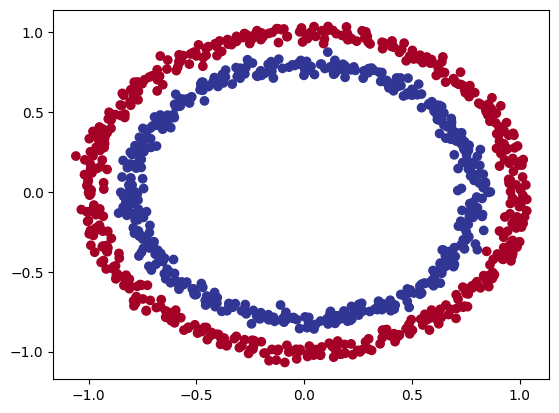

In [8]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### Input and output shapes

What shapes are my inputs and what shapes are my outputs?

In [10]:
X.shape ,  y.shape

((1000, 2), (1000,))


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test splits

In [12]:
# turn the data in to tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [15]:
X[:5] , y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [18]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

- Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
- Constructing a model by subclassing nn.Module.
- Defining a loss function and optimizer.
- Creating a training loop (this'll be in the next section).

In [19]:
import torch
from torch import nn

# select the devide
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'


Excellent, now device is setup, we can use it for any data or models we create and PyTorch will handle it on the CPU (default) or GPU if it's available.

How about we create a model?

We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as outputs.

In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of X and y.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:

Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
Defines a forward() method containing the forward pass computation of the model.
Instantiates the model class and sends it to the target device.

In [21]:
# 1. Construct the model class that subclasses the nn.Module
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes

        self.layer_1 = nn.Linear(in_features=2 , out_features=5) # Takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5 , out_features=1)  # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def faward(self , x):
        # Return the output of layer_2, a single feature, the same shape as y
        out_from_layer_1 = self.layer_1(x)
        return self.layer_2(out_from_layer_1)


# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### You can also do the same as above using nn.Sequential.

In [23]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2667],
        [-0.4355],
        [-0.0376],
        [-0.3308],
        [-0.3764],
        [-0.4768],
        [-0.6837],
        [-0.6942],
        [-0.0236],
        [-0.4506]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

- For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

- And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

![image](./images/3.png)

PyTorch has two binary cross entropy implementations:

torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).
Which one should you use?

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

In [25]:
# loss funciton
loss_fn = nn.BCEWithLogitsLoss()

# create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters() , lr= 0.001)

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

In [26]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Train model

Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [27]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2667],
        [-0.4355],
        [-0.0376],
        [-0.3308],
        [-0.3764]], grad_fn=<SliceBackward0>)

![image](./images/4.png)

In [28]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4337],
        [0.3928],
        [0.4906],
        [0.4181],
        [0.4070]], grad_fn=<SigmoidBackward0>)

In [29]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full (Rounds elements of input to the nearest integer.)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

### Building a training and testing loop

In [30]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71386, Accuracy: 42.00% | Test loss: 0.70745, Test acc: 43.00%
Epoch: 10 | Loss: 0.71369, Accuracy: 41.75% | Test loss: 0.70729, Test acc: 43.00%
Epoch: 20 | Loss: 0.71353, Accuracy: 41.62% | Test loss: 0.70713, Test acc: 43.50%
Epoch: 30 | Loss: 0.71336, Accuracy: 41.62% | Test loss: 0.70697, Test acc: 43.50%
Epoch: 40 | Loss: 0.71320, Accuracy: 41.38% | Test loss: 0.70681, Test acc: 44.00%
Epoch: 50 | Loss: 0.71304, Accuracy: 41.38% | Test loss: 0.70665, Test acc: 43.50%
Epoch: 60 | Loss: 0.71288, Accuracy: 41.12% | Test loss: 0.70650, Test acc: 43.50%
Epoch: 70 | Loss: 0.71272, Accuracy: 41.00% | Test loss: 0.70634, Test acc: 43.50%
Epoch: 80 | Loss: 0.71257, Accuracy: 41.00% | Test loss: 0.70619, Test acc: 43.00%
Epoch: 90 | Loss: 0.71241, Accuracy: 41.00% | Test loss: 0.70604, Test acc: 43.00%


### Make predictions and evaluate the model

In [31]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

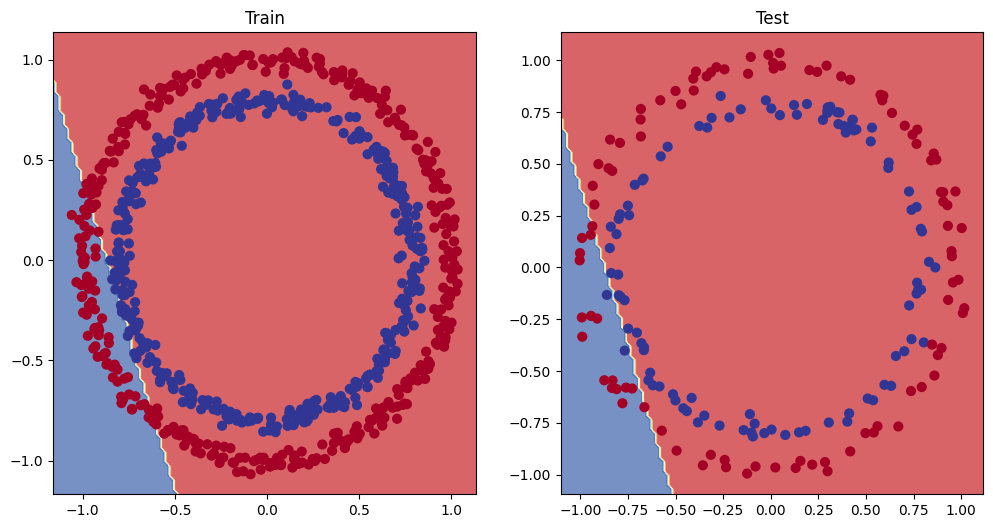

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

> It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

How could we improve this?